In [41]:
import warnings
warnings.filterwarnings('ignore')

# Adversarial Noise
The basic idea of this task is simple and clear: to misleading a pre-trained network with additive noise. Thus, I am going to implement the framework with the following steps:
1. decide a pre-trained model (resnet50 or resent18 from torchvision);
2. given an input image (for example, from imagenet), and use an learnable additive noise, consider the distance between the prediction and the target label as the loss;
3. freeze the resnet, but calculate the gradients during the backpropagation, to pass the information to the noise;
4. update the noise;
5. stop the iterations until meeting the condition (for example, confidence > threshold).

In [52]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

# Load the pre-trained model
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
model.eval()  # Set the model to evaluation mode

preprocess = weights.transforms()

def predict(image):
    # Apply inference preprocessing transforms
    batch = preprocess(image).unsqueeze(0)
    # Use the model and print the predicted category
    prediction = model(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    print(f"{category_name}: {100 * score}%")
    
    return category_name, score


In [24]:
print(weights.meta["categories"])

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'diamondback', 

In [77]:
# Set random seed for reproducibility
torch.manual_seed(42)
loss_fn = torch.nn.CrossEntropyLoss()

# FGSM Attack
def adversarial_noise_attack(image, target_label, goal=None):
    """
    Implement Adversarial Noise Attack 
    :param image: the original image, can be a PIL
    :param target_label: the target label, should be included in ImageNet 1000 classes
    :param goal: the condition to stop:
        None (default), and 'targeted': the pretrained model will output the target label;
        int (0 - 99), for example, 85: confidence of target label is higher than the threshold  
    :return: 
    """
    lr = 0.01
    epsilon = 0.1
    target_index = [i for i, l in enumerate(weights.meta["categories"]) if target_label in l]
    if len(target_index) == 0:
        raise "No such label"
    target_index = target_index[0]
    
    # image to tensor first
    transform = transforms.Compose([
        transforms.ToTensor(),  # This converts the image to a tensor
        # Add any other transformations here (e.g., resizing, normalization)
    ])
    img_tensor = transform(image)
    
    # Initialize noise
    noise = torch.zeros_like(img_tensor, requires_grad=True)
    # Set the optimizer (here, we use Adam)
    optimizer = torch.optim.Adam([noise], lr=lr)
    
    for i in range(100):
        optimizer.zero_grad()
        noisy_image = noise + img_tensor
        noisy_image = torch.clamp(noisy_image, 0, 1)
        noisy_image = preprocess(noisy_image).unsqueeze(0)
        # Use the model and print the predicted category
        output = model(noisy_image).squeeze(0).softmax(0)
        
        #
        class_id = output.argmax().item()
        predict_score = output[class_id].item()
        predict_category = weights.meta["categories"][class_id]
        target_label_score = output[target_index].item()
        print('Interation {}/100 done!'.format(i))
        print(f"{predict_category}: {100 * predict_score}%")
        print(f"{target_label}: {100 * target_label_score}%")
        
        # Already meet the target?
        if goal is None or goal == 'targeted':
            if output.argmax().item() == target_index:
                break
        elif isinstance(goal, int):
            if target_label_score * 100 > goal:
                break
        
        # update the noise
        loss = loss_fn(output.unsqueeze(0), torch.tensor([target_index]))
        loss.backward()
        optimizer.step()
        
        # Optional: Add constraints to keep the noise imperceptible
        noise.data = torch.clamp(noise.data, -epsilon, epsilon)
        
    noisy_image = noise + img_tensor
    noisy_image = torch.clamp(noisy_image, 0, 1)
    
    # from Tensor to Image: noise, and noisy_image
    transform_to_image = transforms.ToPILImage()
    # noise = transform_to_image(noise)
    noisy_image = transform_to_image(noisy_image)
    
    return noise, noisy_image


In [76]:
import matplotlib.pyplot as plt

def plot_images(ori_img, ori_pred, ori_score, attacked_img, attacked_pred, attacked_score, noise):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Set up a figure with three subplots
    
    # Plot original image
    axs[0].imshow(ori_img)
    axs[0].set_title(f"Original Image: {ori_pred} {ori_score:.2f}")
    axs[0].axis('off')  # Hide axis for cleaner visualization
    
    # Plot attacked image
    axs[1].imshow(attacked_img)
    axs[1].set_title(f"Attacked Image: {attacked_pred} {attacked_score:.2f}")
    axs[1].axis('off')  # Hide axis for cleaner visualization
    
    # Plot noise
    noise_np = noise.permute(1, 2, 0).detach().numpy()
    # # Scaling to [0, 1] range:
    # noise_min = noise_np.min()
    # noise_max = noise_np.max()
    # noise_scaled = (noise_np - noise_min) / (noise_max - noise_min)
    
    # Plot the scaled noise
    noise_plt = axs[2].imshow(noise_np.mean(axis=2), cmap='viridis')
    axs[2].axis('off')  # Hide the axis
    fig.colorbar(noise_plt, ax=axs[2], fraction=0.036, pad=0.04)  # Add a colorbar
    
    plt.show()
    plt.tight_layout()
    plt.show()

torch.Size([3, 577, 700]) torch.float32 tensor(1.) tensor(0.)
preprocess ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
torch.Size([3, 224, 224]) torch.float32 tensor(2.6400) tensor(-1.9261)
Labrador retriever: 12.254486978054047%
Interation 0/100 done!
Labrador retriever: 12.15331256389618%
goldfish: 0.09071814129129052%
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Interation 1/100 done!
Labrador retriever: 6.437791138887405%
goldfish: 0.18856575479730964%
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector

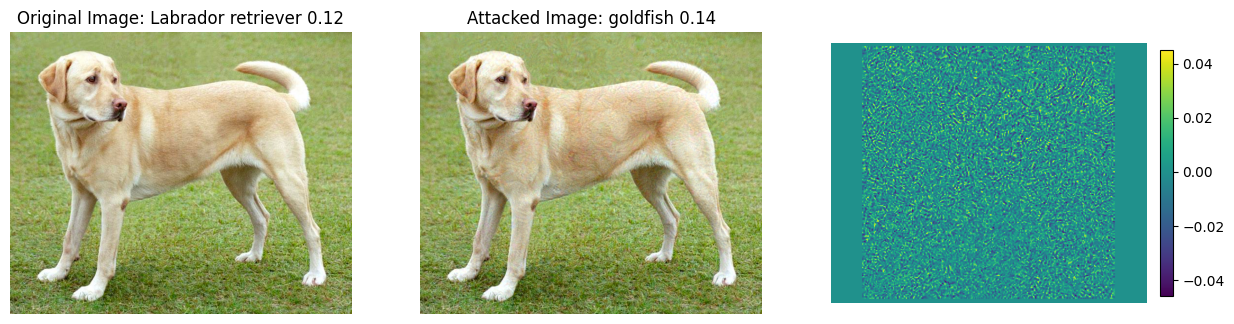

<Figure size 640x480 with 0 Axes>

Interation 0/100 done!
Labrador retriever: 12.15331256389618%
goldfish: 0.09071814129129052%
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Interation 1/100 done!
Labrador retriever: 6.437791138887405%
goldfish: 0.18856575479730964%
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Interation 2/100 done!
Labrador retriever: 5.582240596413612%
goldfish: 0.6896317936480045%
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (

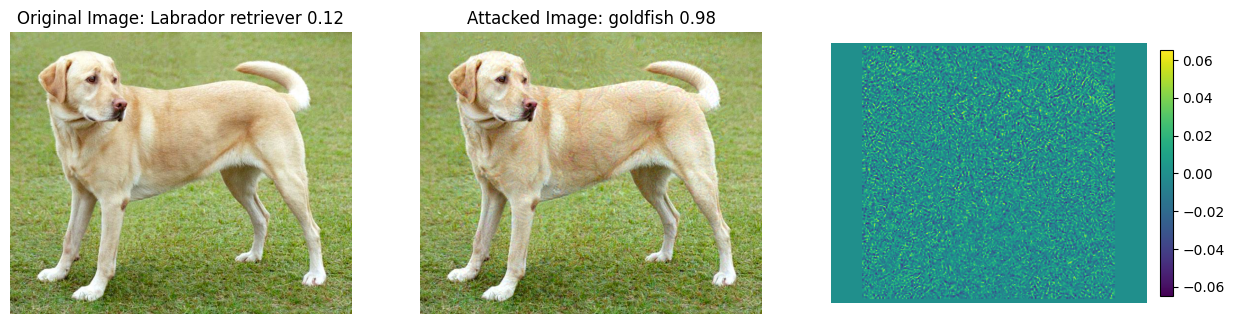

<Figure size 640x480 with 0 Axes>

In [79]:
target_label = 'goldfish'
# Load your image
img = Image.open("dog_example.png").convert("RGB")
transform = transforms.Compose([
    transforms.ToTensor(),  # This converts the image to a tensor
    # Add any other transformations here (e.g., resizing, normalization)
])
img_tensor = transform(img)
print(img_tensor.shape, img_tensor.dtype, img_tensor.max(), img_tensor.min())

print('preprocess', preprocess)
imt = preprocess(img_tensor)
print(imt.shape, imt.dtype, imt.max(), imt.min())

# original prediction
ori_pred, ori_score = predict(img)

# Attack 1: targeted label
noise, noisy_image = adversarial_noise_attack(img, target_label)
attacked_pred, attacked_score = predict(noisy_image)
plot_images(img, ori_pred, ori_score, noisy_image, attacked_pred, attacked_score, noise)

# Attack 2: confidence > 85%
noise, noisy_image = adversarial_noise_attack(img, target_label, goal=85)

attacked_pred, attacked_score = predict(noisy_image)

plot_images(img, ori_pred, ori_score, noisy_image, attacked_pred, attacked_score, noise)


